##Multilevel Origin-Destination Direct Ridership Model

first load some utility/plotting packages for mixed models

In [5]:
lib <- c("foreign", "nlme", "lme4", "car", "descr", "effects", "xtable",  "sas7bdat", "texreg", "lmtest", "Hmisc", "ggplot2")
require(lib)
lapply(lib, require, character.only=T)

Loading required package: lib
Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, : there is no package called ‘lib’Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

include a nice convenience function for plotting random effects courtesy of [caracal](http://stackoverflow.com/users/484139/caracal) from [this post](http://stackoverflow.com/questions/13847936/in-r-plotting-random-effects-from-lmer-lme4-package-using-qqmath-or-dotplot)

In [2]:
## re = object of class ranef.mer
ggCaterpillar <- function(re, QQ=TRUE, likeDotplot=TRUE) {
  require(ggplot2)
  f <- function(x) {
    pv   <- attr(x, "postVar")
    cols <- 1:(dim(pv)[1])
    se   <- unlist(lapply(cols, function(i) sqrt(pv[i, i, ])))
    ord  <- unlist(lapply(x, order)) + rep((0:(ncol(x) - 1)) * nrow(x), each=nrow(x))
    pDf  <- data.frame(y=unlist(x)[ord],
                       ci=1.96*se[ord],
                       nQQ=rep(qnorm(ppoints(nrow(x))), ncol(x)),
                       ID=factor(rep(rownames(x), ncol(x))[ord], levels=rownames(x)[ord]),
                       ind=gl(ncol(x), nrow(x), labels=names(x)))
    
    if(QQ) {  ## normal QQ-plot
      p <- ggplot(pDf, aes(nQQ, y))
      p <- p + facet_wrap(~ ind, scales="free")
      p <- p + xlab("Standard normal quantiles") + ylab("Random effect quantiles")
    } else {  ## caterpillar dotplot
      p <- ggplot(pDf, aes(ID, y)) + coord_flip()
      if(likeDotplot) {  ## imitate dotplot() -> same scales for random effects
        p <- p + facet_wrap(~ ind)
      } else {           ## different scales for random effects
        p <- p + facet_grid(ind ~ ., scales="free_y")
      }
      p <- p + xlab("Levels") + ylab("Random effects")
    }
    
    p <- p + theme(legend.position="none")
    p <- p + geom_hline(yintercept=0)
    p <- p + geom_errorbar(aes(ymin=y-ci, ymax=y+ci), width=0, colour="black")
    p <- p + geom_point(aes(size=1.2), colour="blue") 
    return(p)
  }
  
  lapply(re, f)
}


Read the latest data file from WMATA and remove OD pairs with no ridership

In [3]:
wmata <- read.dta('Data/Collapsed_Example_0616_Hiro1.dta')
wmata <- subset(wmata, log(ridersum) >0)

test some null models

In [10]:
null_model <- gls( log(ridersum) ~ 1, data=wmata)
null_model_o <- lme( log(ridersum) ~ 1, random =~ 1 | mstn_id_o, data = wmata)
null_model_d <- lme( log(ridersum) ~ 1, random =~ 1 | mstn_id_d, data = wmata)
null_model_od <- lmer (log(ridersum) ~ 1 +(1| mstn_id_d) + (1| mstn_id_o), data = wmata)


In [12]:
anova(null_model, null_model_o)
anova(null_model, null_model_d)

Model df      AIC      BIC    logLik   Test  L.Ratio p-value
null_model       1  2 27496.33 27510.02 -13746.16                        
null_model_o     2  3 26629.78 26650.32 -13311.89 1 vs 2 868.5514  <.0001

Model df      AIC      BIC    logLik   Test  L.Ratio p-value
null_model       1  2 27496.33 27510.02 -13746.16                        
null_model_d     2  3 22930.26 22950.80 -11462.13 1 vs 2 4568.071  <.0001

In [14]:
lrtest(null_model_o, null_model_od)
lrtest(null_model_d, null_model_od)

Warning message:
In modelUpdate(objects[[i - 1]], objects[[i]]): original model was of class "lme", updated model is of class "lmerMod"

Likelihood ratio test

Model 1: log(ridersum) ~ 1
Model 2: log(ridersum) ~ 1 + (1 | mstn_id_d) + (1 | mstn_id_o)
  #Df LogLik Df  Chisq Pr(>Chisq)    
1   3 -13312                         
2   4 -10221  1 6181.6  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message:
In modelUpdate(objects[[i - 1]], objects[[i]]): original model was of class "lme", updated model is of class "lmerMod"

Likelihood ratio test

Model 1: log(ridersum) ~ 1
Model 2: log(ridersum) ~ 1 + (1 | mstn_id_d) + (1 | mstn_id_o)
  #Df LogLik Df Chisq Pr(>Chisq)    
1   3 -11462                        
2   4 -10221  1  2482  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

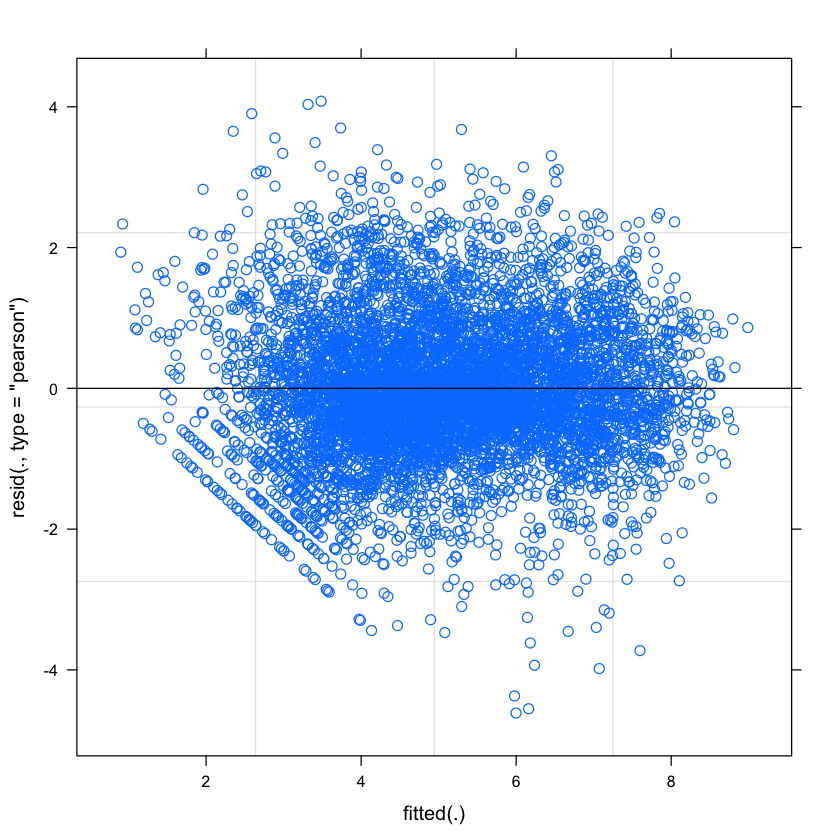

In [15]:
plot(null_model_od)

Warning message:
: ‘mode(antialias)’ differs between new and previous
	 ==> NOT changing ‘antialias’

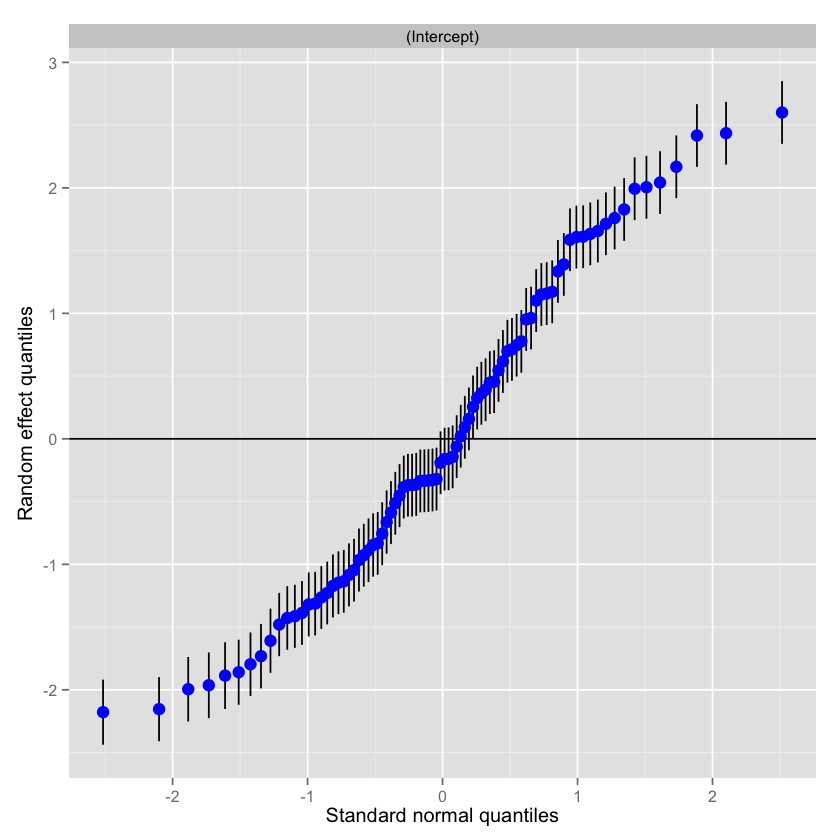

Warning message:
: ‘mode(antialias)’ differs between new and previous
	 ==> NOT changing ‘antialias’

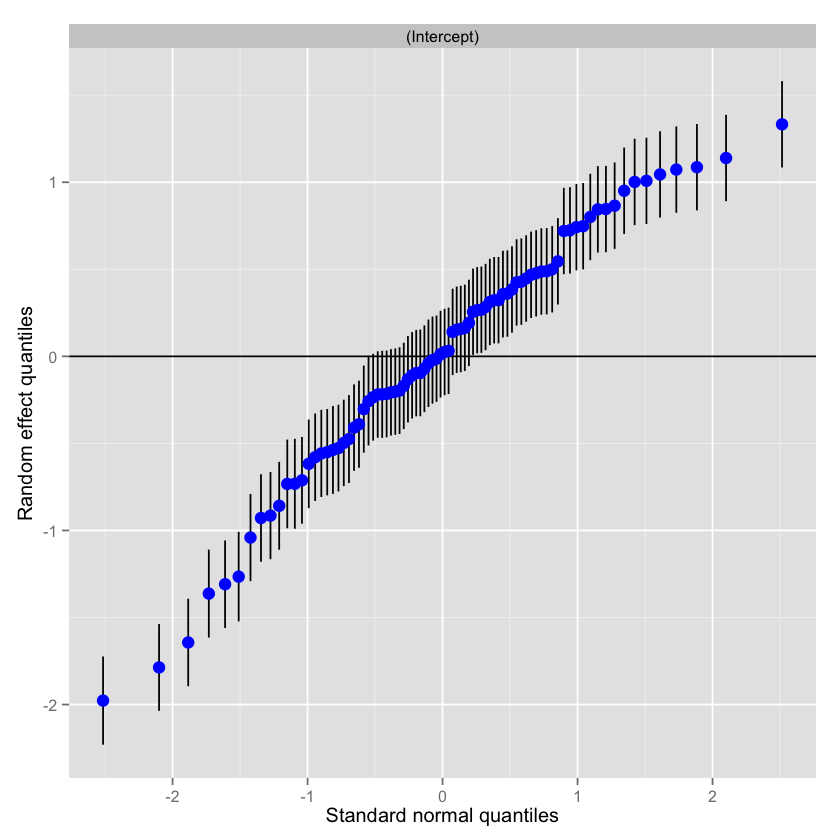

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$mstn_id_d

$mstn_id_o


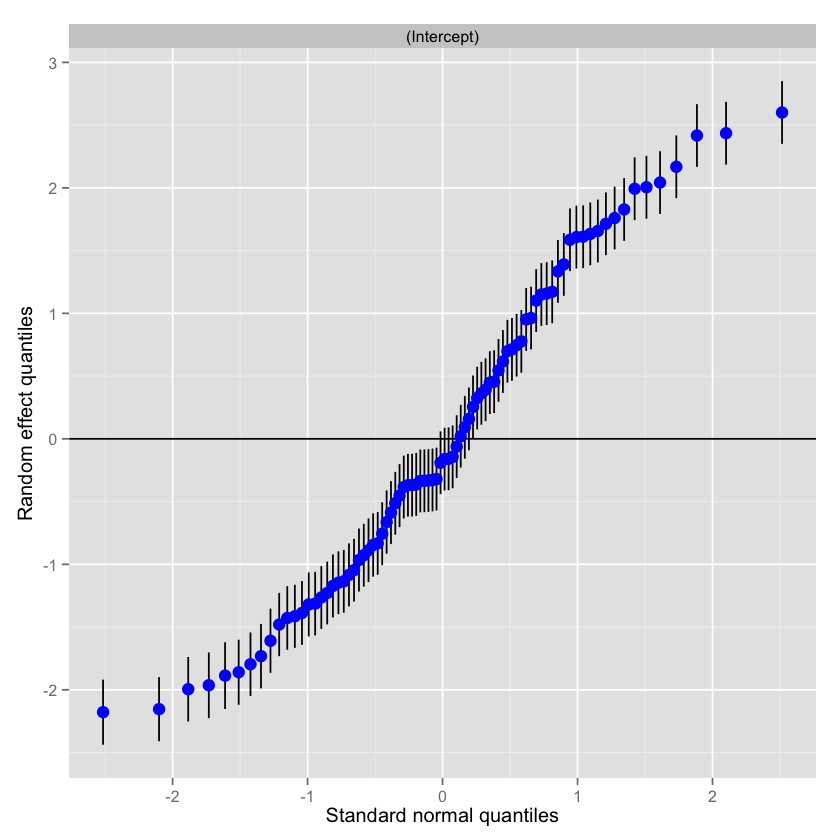

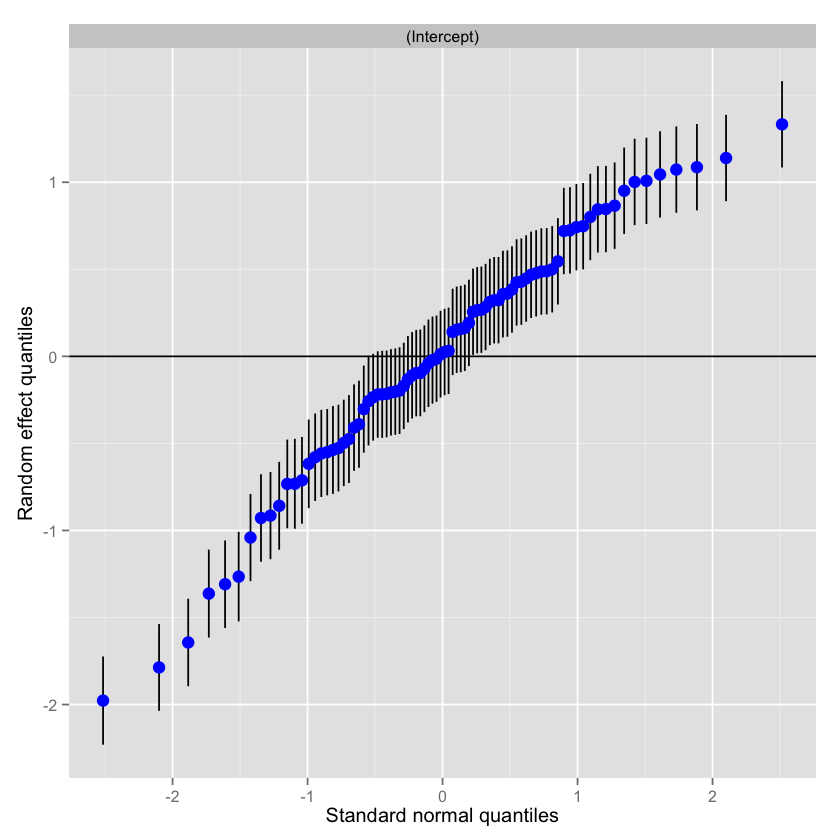

In [17]:
ggCaterpillar(ranef(null_model_od, condVar=TRUE))  ## using ggplot2